In [1]:
# libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import requests

In [2]:
def send_message(message, channel):
    requests.post(f"https://ntfy.sh/{channel}",
        data=message.encode(encoding='utf-8'))

In [3]:
def gaussian_kernel1(a,b, sigma = 0.1620289):
    return np.exp(-((a-b)**2)*sigma)

def gaussian_kernel2(a,b, sigma = 38.9827449):
    a = np.array(a)
    b = np.array(b)
    return np.exp(-(np.linalg.norm(a-b)**2)*sigma)

In [4]:
def count_trips_mibici(data_user, threshold = 5, complement = False):
    viajes_user = data_user.groupby([data_user[['Origen_Id', 'Destino_Id']].min(axis=1), data_user[['Origen_Id', 'Destino_Id']].max(axis=1)]).size().reset_index(name='counts')
    viajes_user.columns = ['Est_A', 'Est_B', 'counts']
    if not complement:
        viajes_user = viajes_user[viajes_user['counts'] >= threshold]
    else:
        viajes_user = viajes_user[viajes_user['counts'] < threshold]
    if viajes_user.empty:
        return None
    total = viajes_user['counts'].sum()
    viajes_user['prob'] = viajes_user['counts']/total
    viajes_user = viajes_user.sort_values(by = 'prob', ascending = False).reset_index(drop=True)
    return viajes_user

In [5]:
def log_prob_matrix(counter_user, normalized = False, self_loops = False):
    if not self_loops:
        counter_user = counter_user[counter_user['Est_A'] != counter_user['Est_B']]
    vertex = list(set(counter_user['Est_A'].unique().tolist() + counter_user['Est_B'].unique().tolist()))
    matrix = np.zeros((len(vertex), len(vertex)))
    for i in range(len(counter_user)):
        current_trip = counter_user.iloc[i]
        count = -np.log(current_trip["prob"])
        estA = current_trip["Est_A"]
        estB = current_trip["Est_B"]

        matrix[vertex.index(estA)][vertex.index(estB)] = count
        matrix[vertex.index(estB)][vertex.index(estA)] = count
    if normalized:
        D = np.sum(matrix, axis = 1)
        D = np.diag(D)
        D = np.linalg.inv(np.sqrt(D))
        matrix = D @ matrix @ D
    return matrix, vertex

In [50]:
def plot_histogram(data, title = 'Histogram', xlabel = 'X', ylabel = 'Frequency', save = False, save_path = None):
    bins = np.log2(len(data)).astype(int) + 1
    maximum = np.max(data)
    minimum = np.min(data)
    plt.plot([], [], ' ', label = f'Maximum: {maximum}')
    plt.plot([], [], ' ', label = f'Minimum: {minimum}')
    plt.hist(data, bins = bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid()
    if save:
        plt.savefig(save_path)
    plt.show()

In [6]:
dir = '/home/user/Desktop/Datos/'
#dir = '/Users/antoniomendez/Desktop/Tesis/Datos/datos_limpios/'

In [57]:
def generate_random_indexes(n_sample, min_value, max_value):
    indexes = []
    for _ in range(n_sample):
        individual = [np.random.randint(min_value, max_value), np.random.randint(min_value, max_value)]
        individual = [min(individual), max(individual)]
        while individual in indexes:
            individual = [np.random.randint(min_value, max_value), np.random.randint(min_value, max_value)]
            individual = [min(individual), max(individual)]
        indexes.append(individual)
    return indexes

In [58]:
indexes = generate_random_indexes(15, 0, 31)

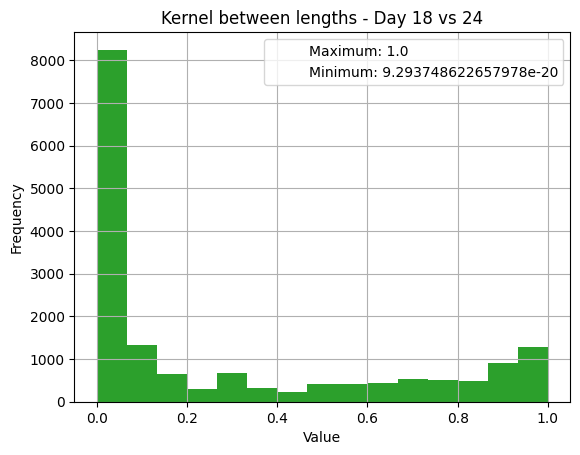

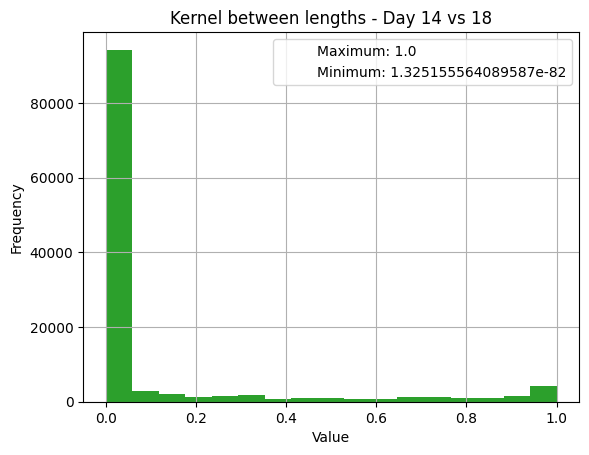

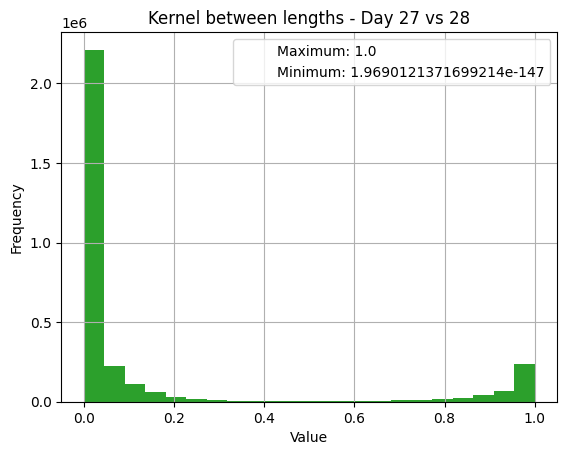

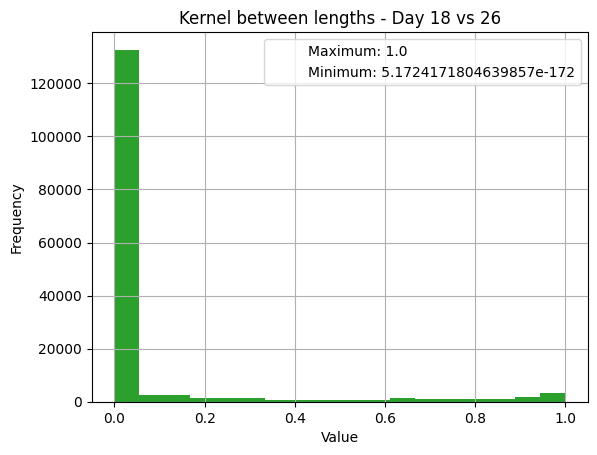

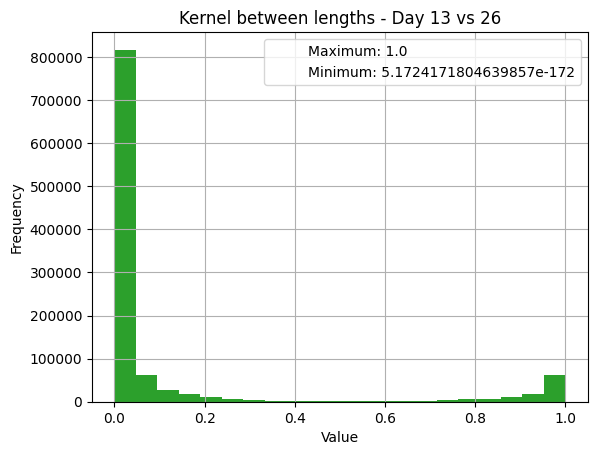

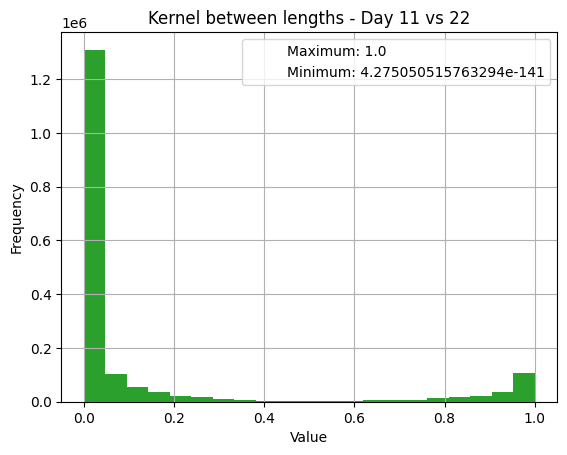

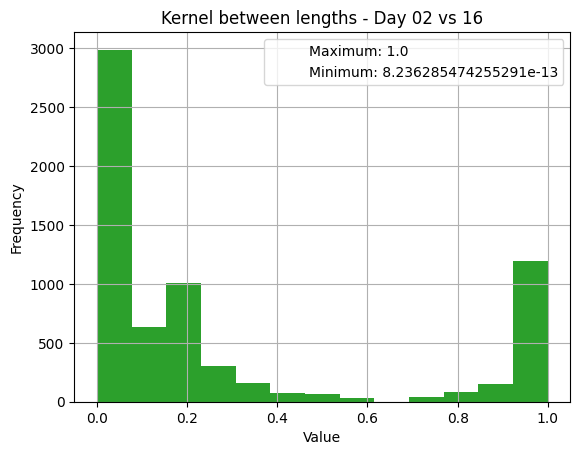

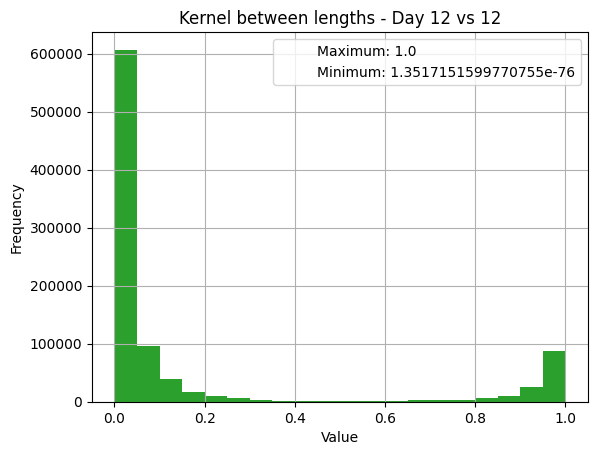

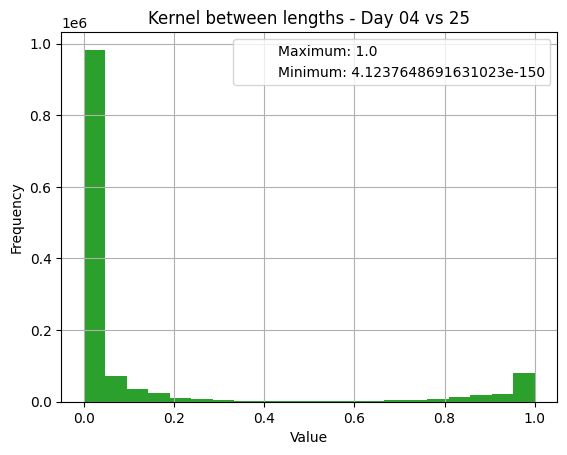

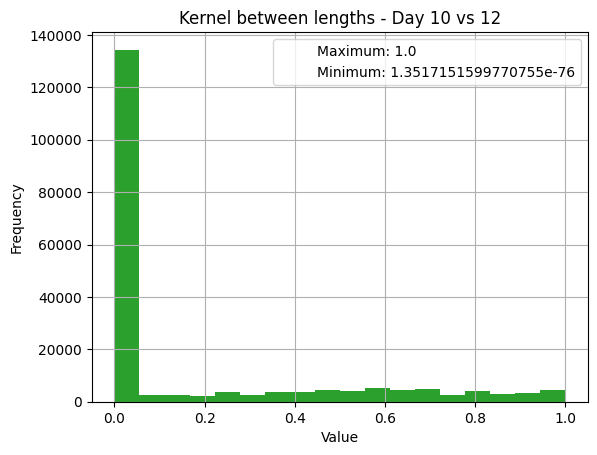

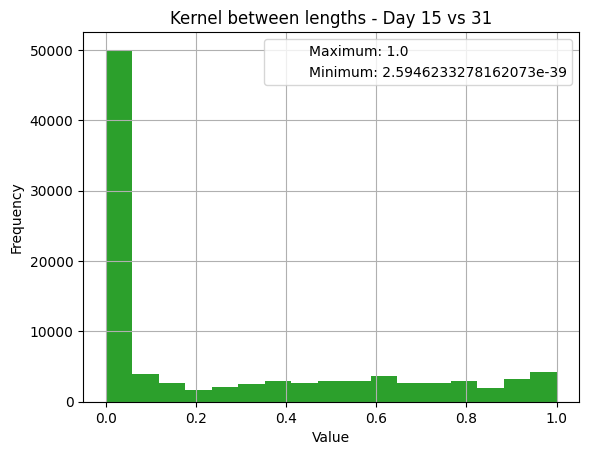

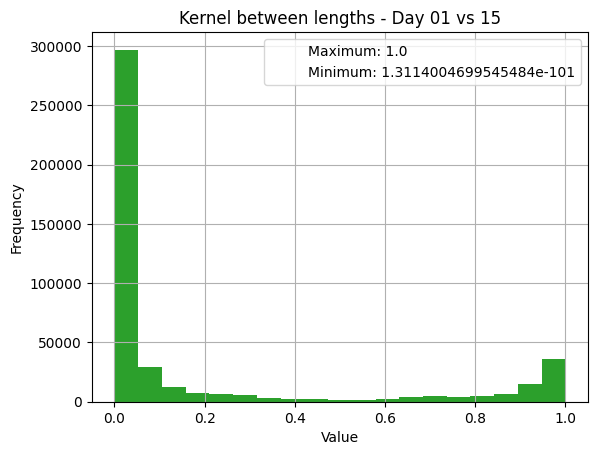

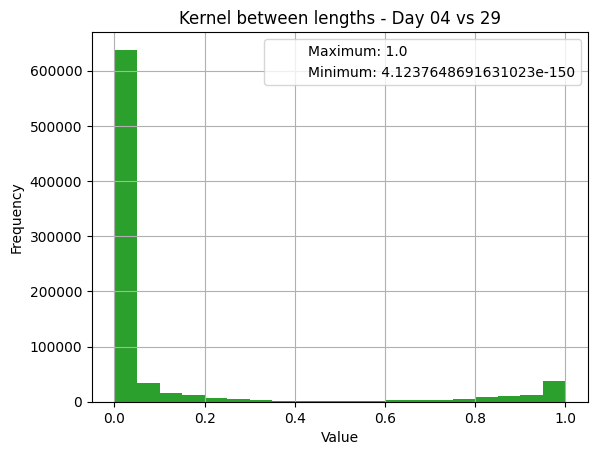

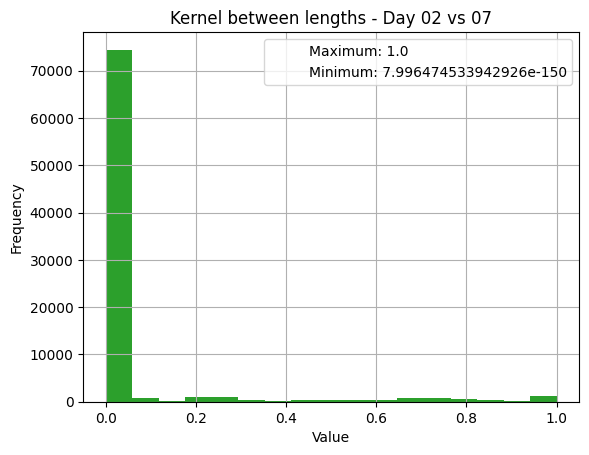

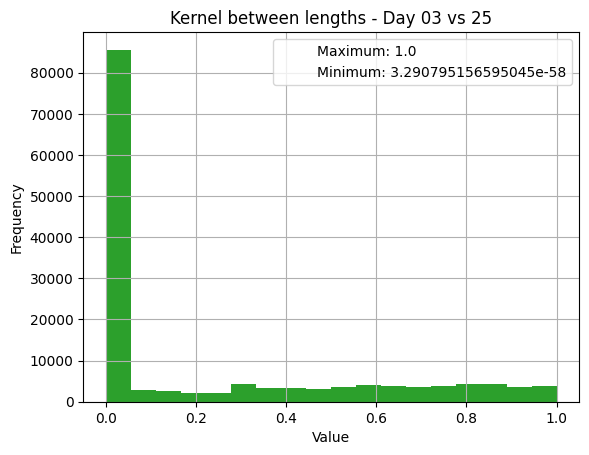

In [61]:
for index in indexes:
    i, j = index
    K = np.load(f'results/K_l_{i}_{j}.npy')
    plot_histogram(K.flatten(), title = f'Kernel between lengths - Day {i+1:02d} vs {j+1:02d}', xlabel = 'Value')

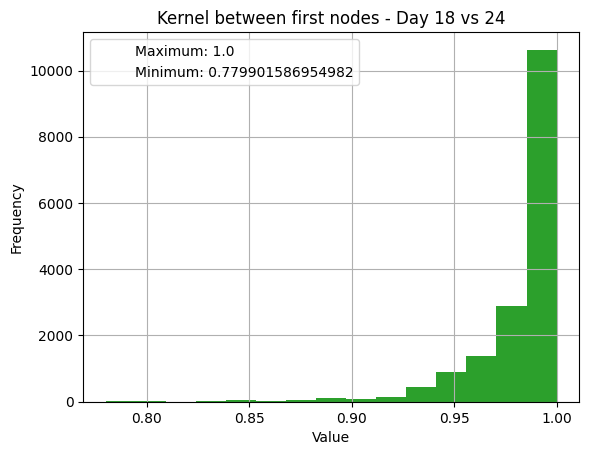

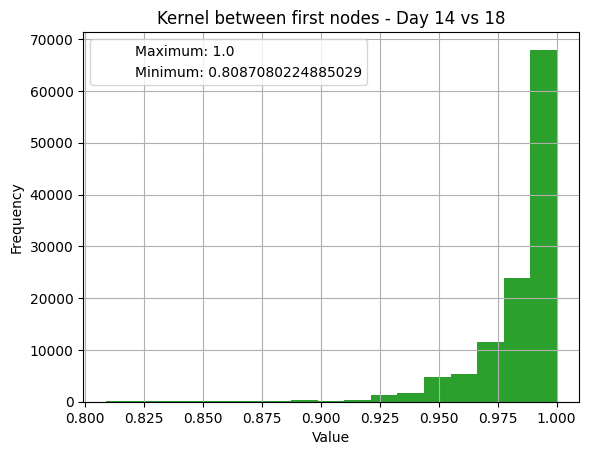

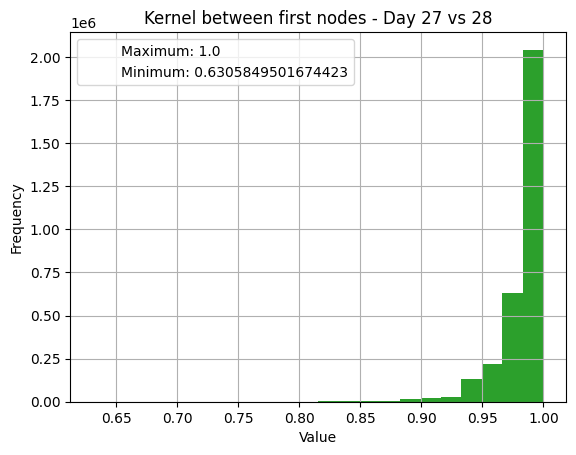

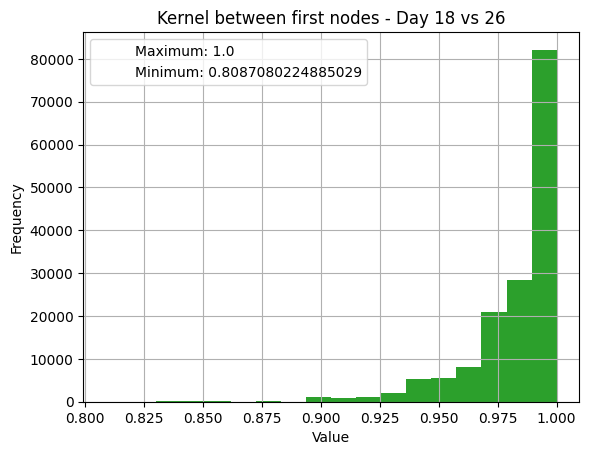

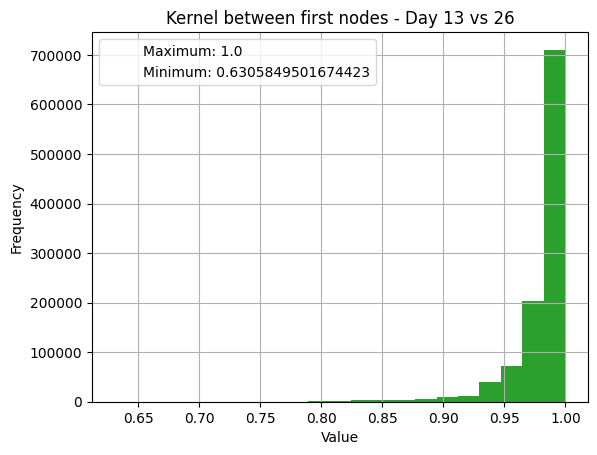

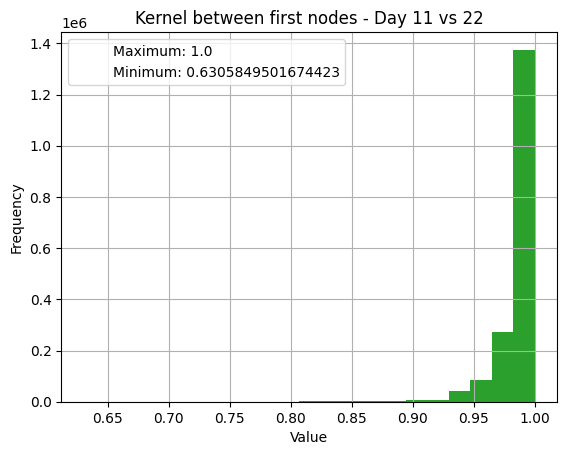

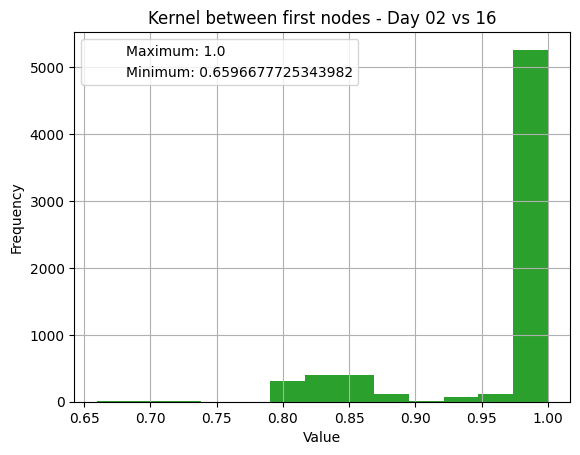

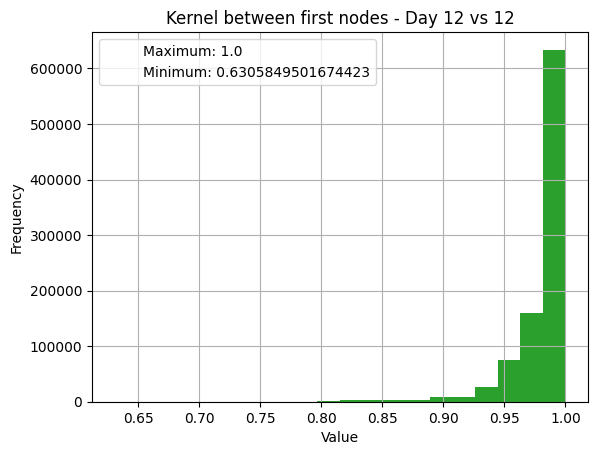

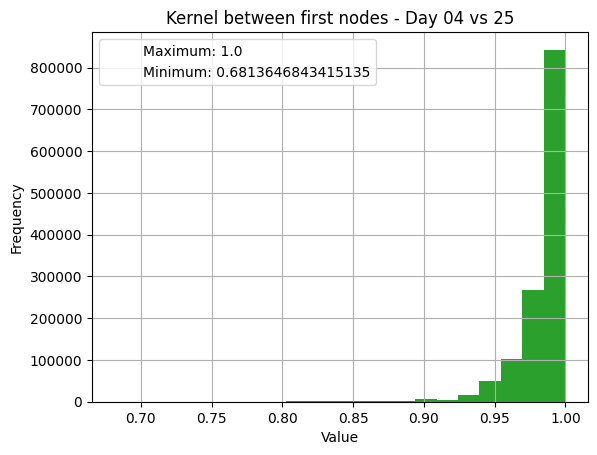

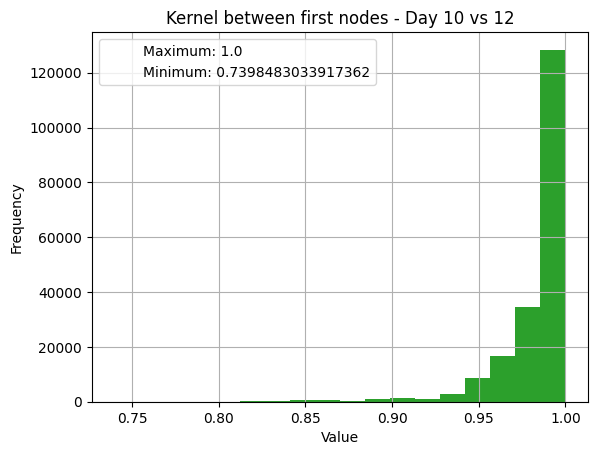

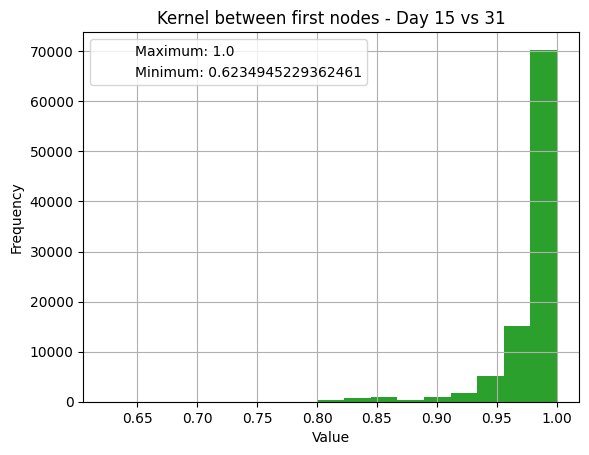

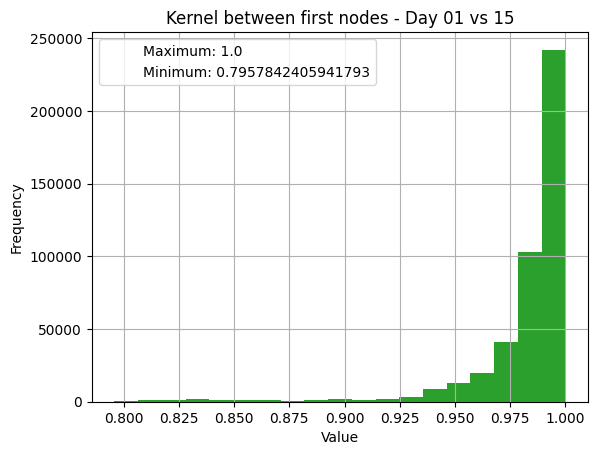

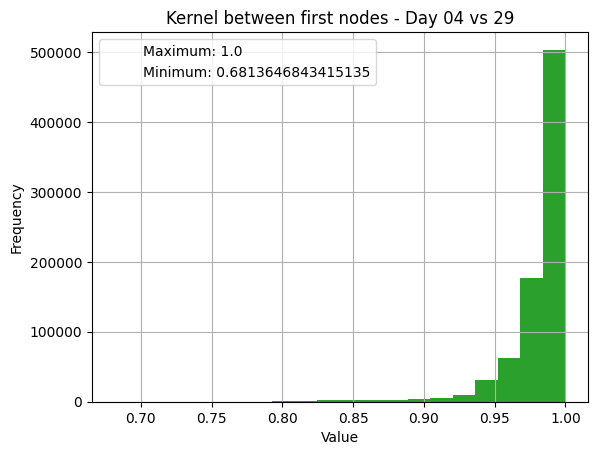

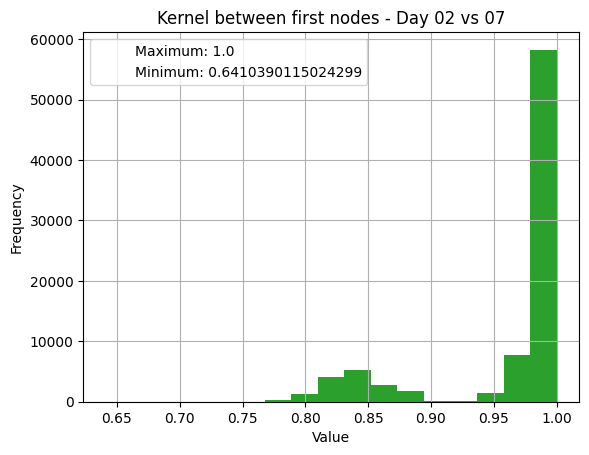

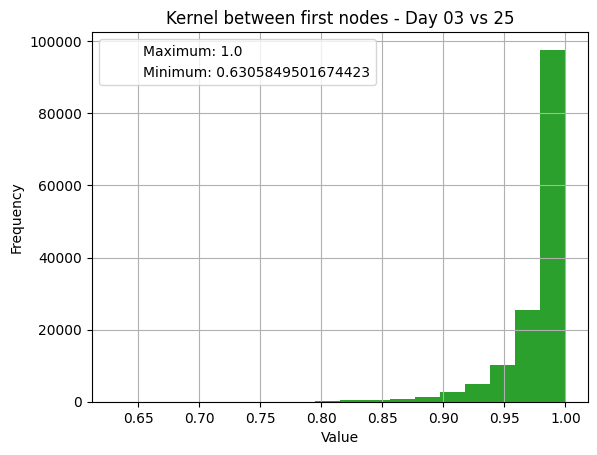

In [62]:
for index in indexes:
    i, j = index
    K = np.load(f'results/K_i_{i}_{j}.npy')
    plot_histogram(K.flatten(), title = f'Kernel between first nodes - Day {i+1:02d} vs {j+1:02d}', xlabel = 'Value')

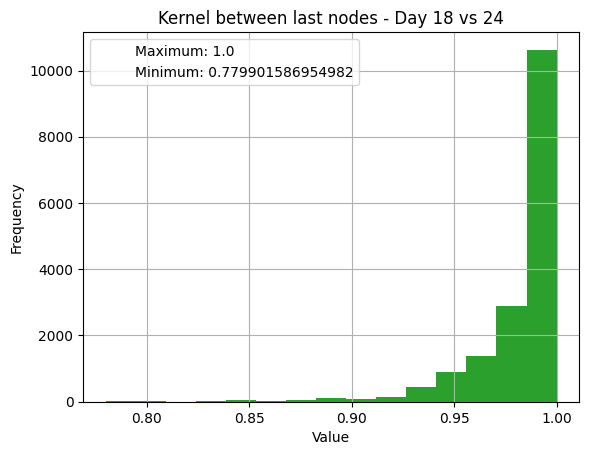

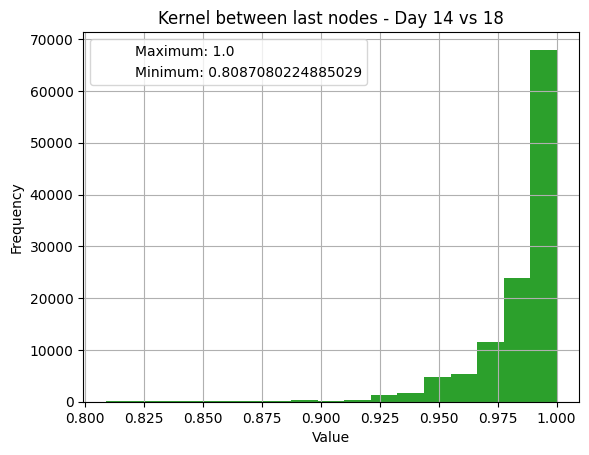

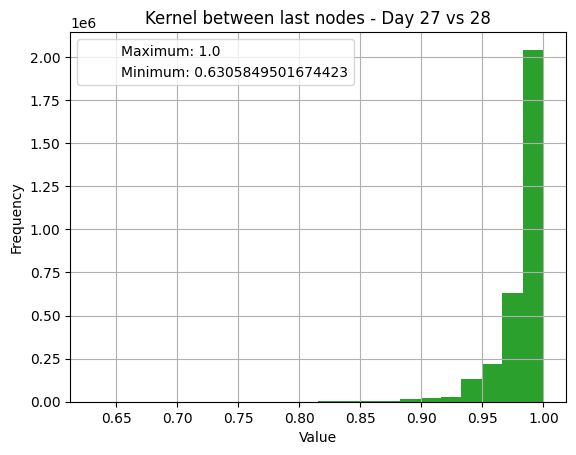

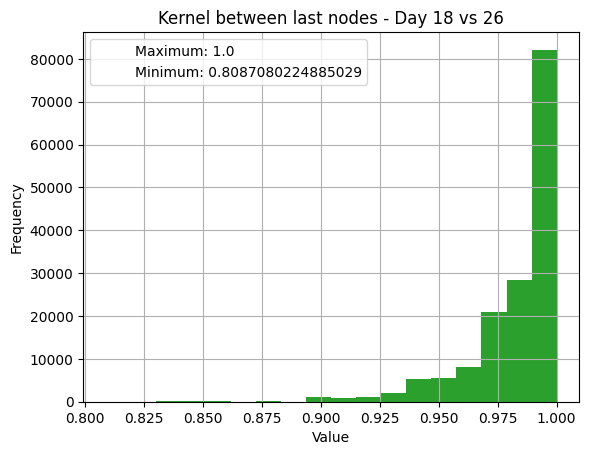

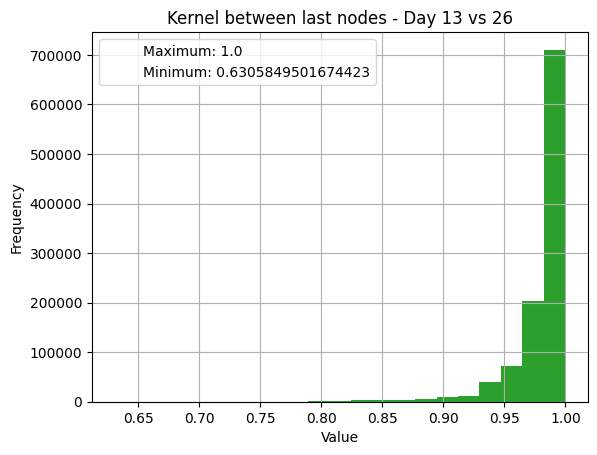

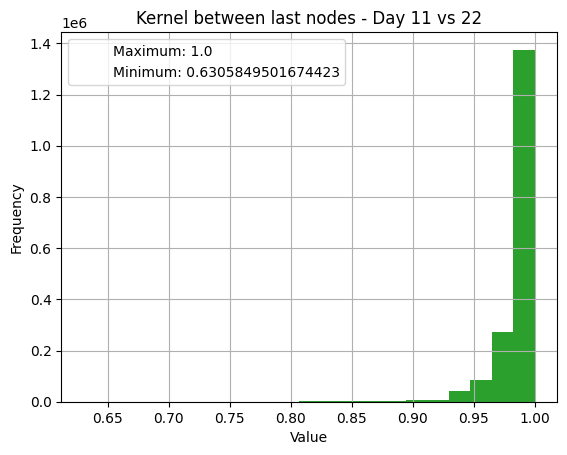

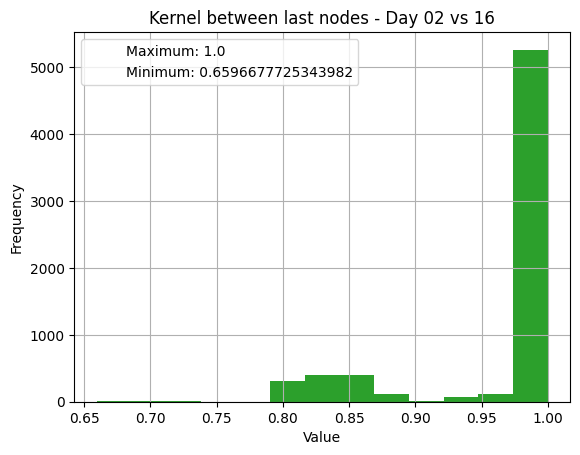

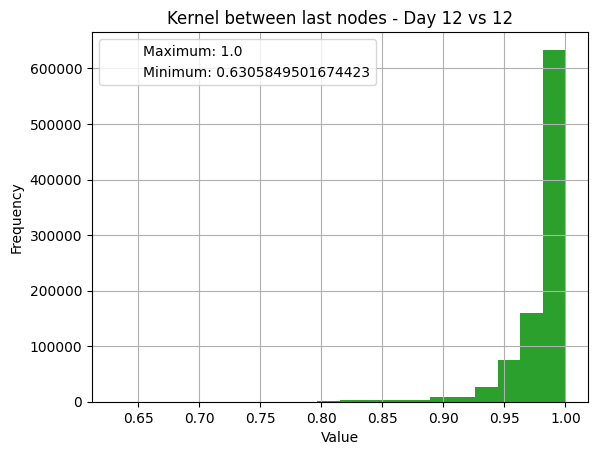

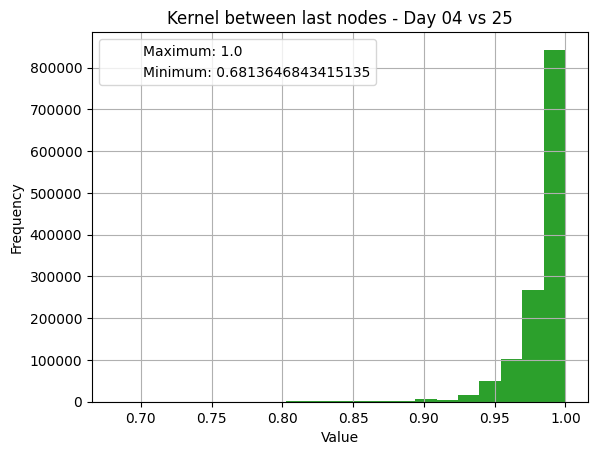

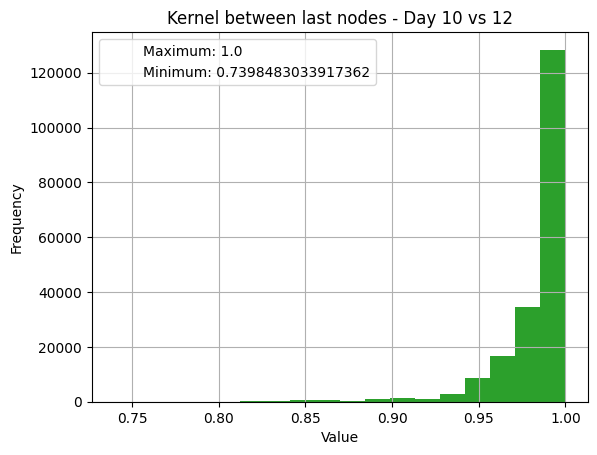

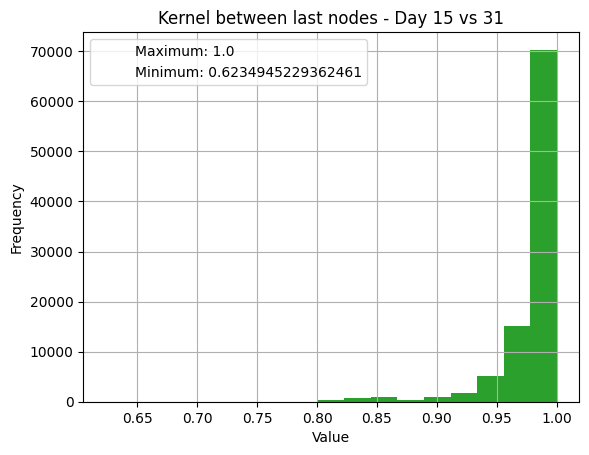

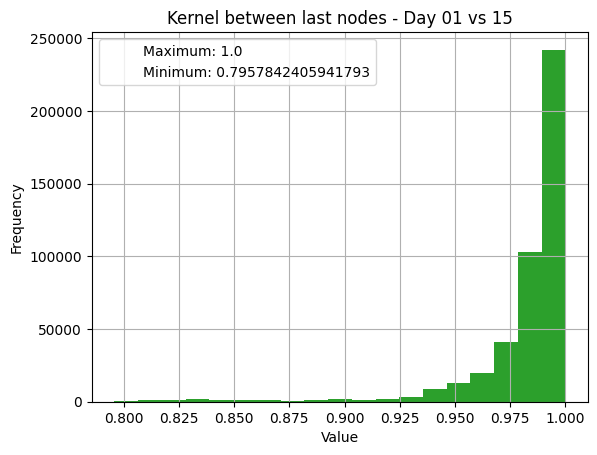

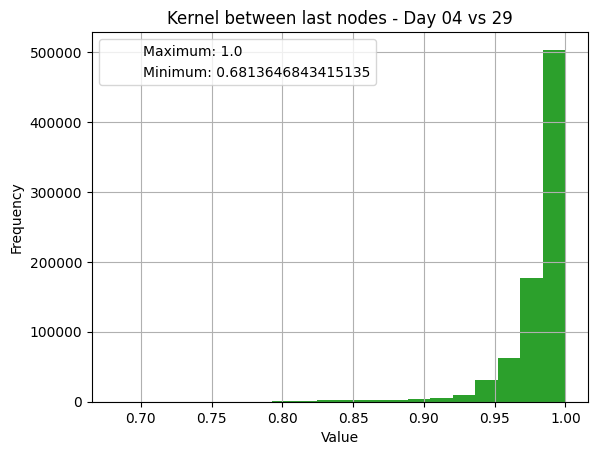

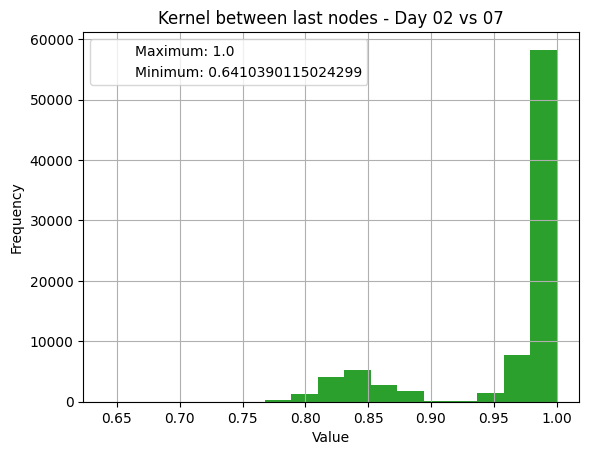

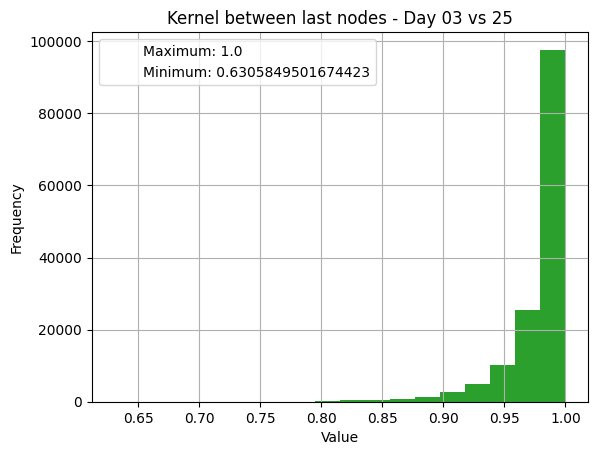

In [63]:
for index in indexes:
    i, j = index
    K = np.load(f'results/K_e_{i}_{j}.npy')
    plot_histogram(K.flatten(), title = f'Kernel between last nodes - Day {i+1:02d} vs {j+1:02d}', xlabel = 'Value')

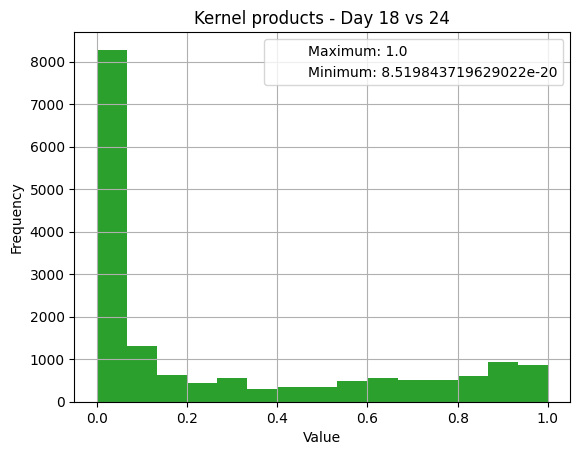

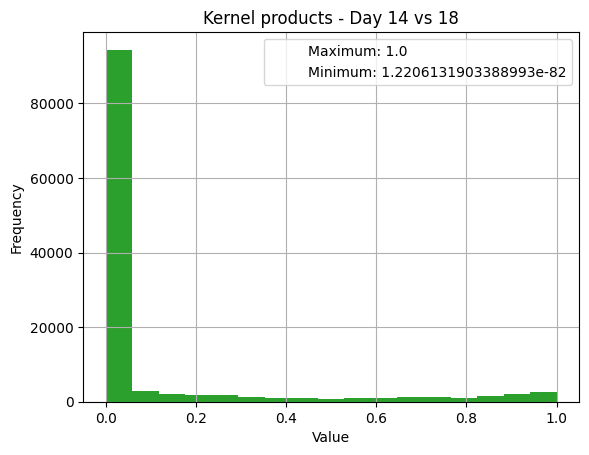

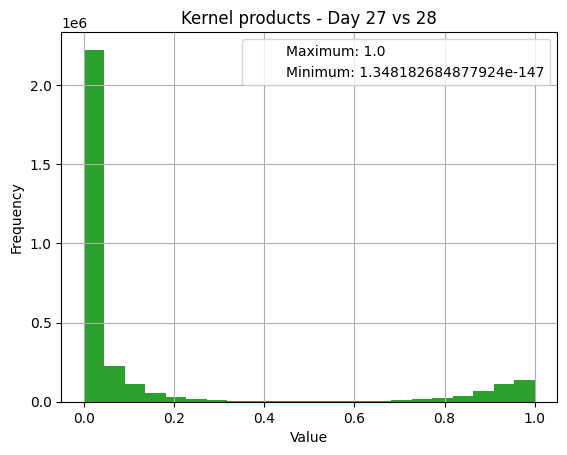

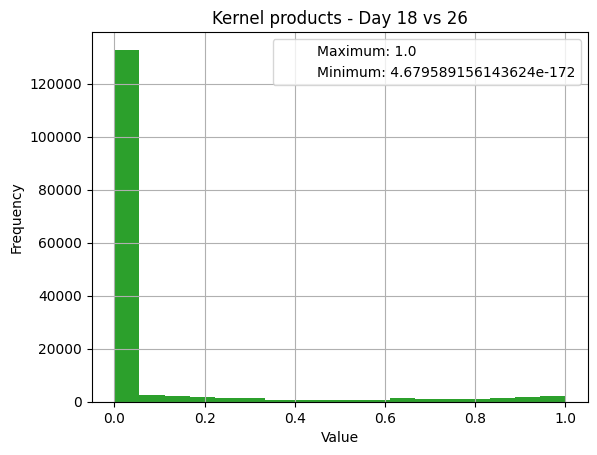

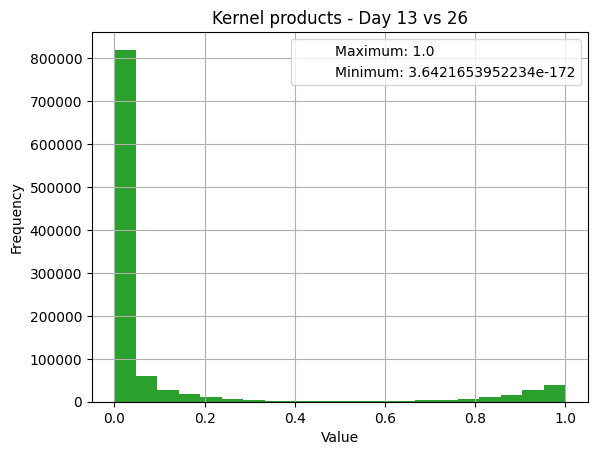

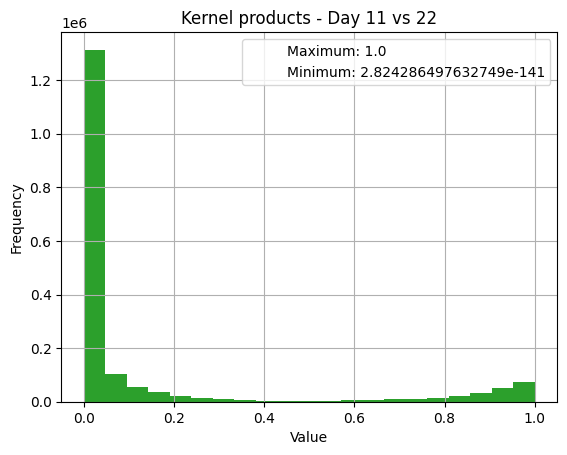

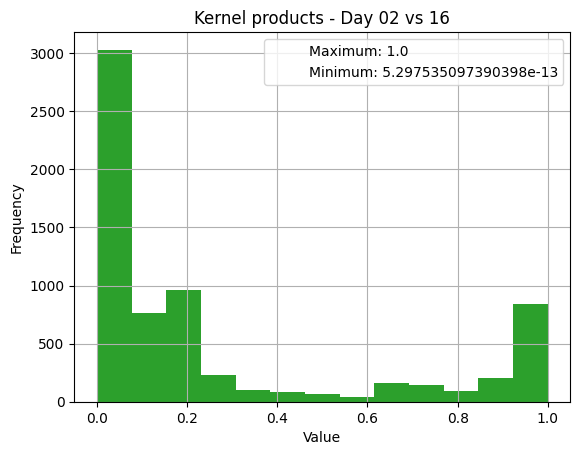

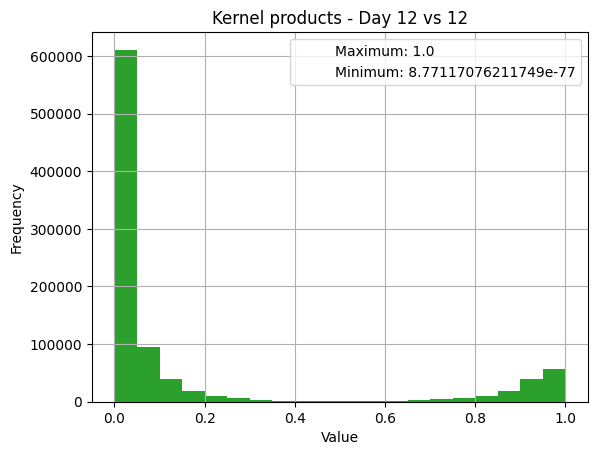

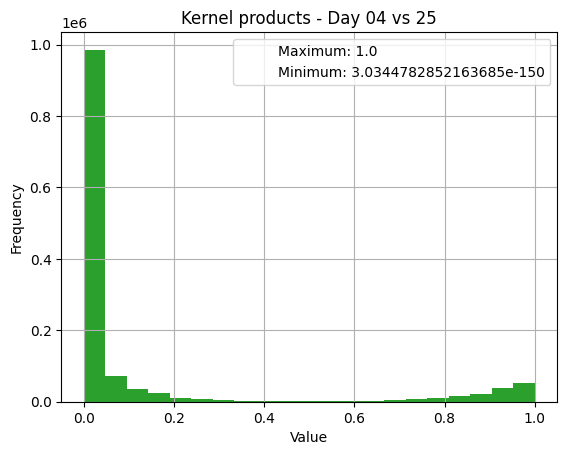

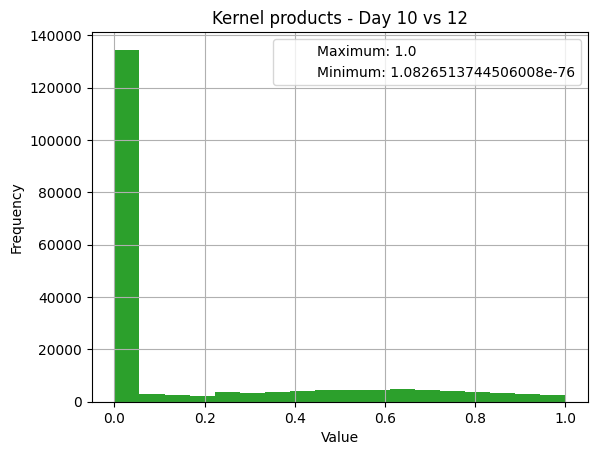

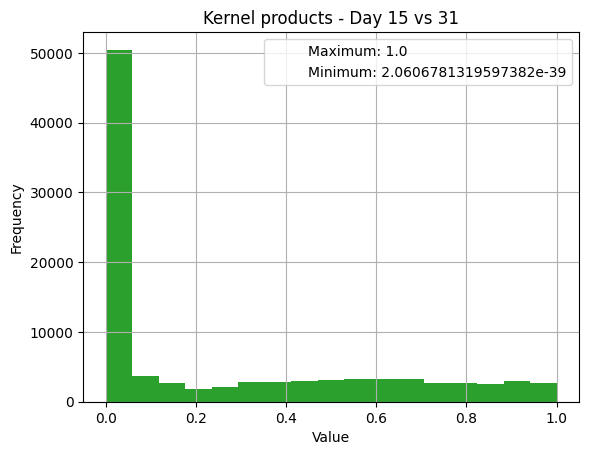

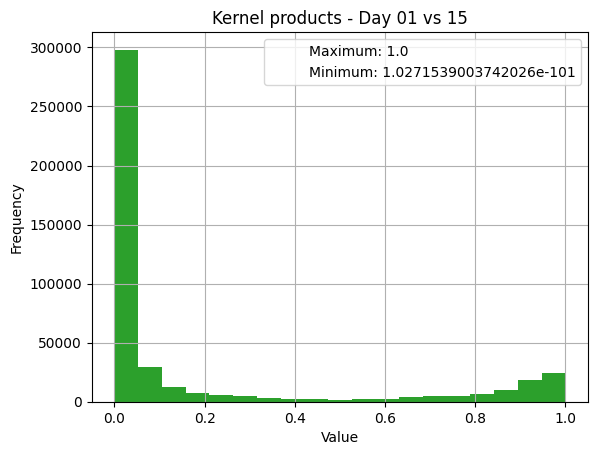

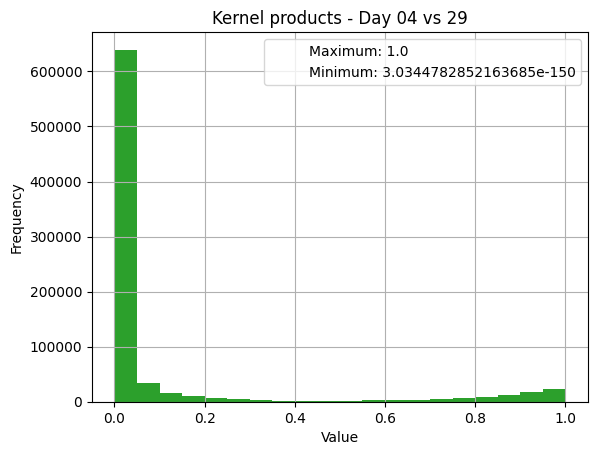

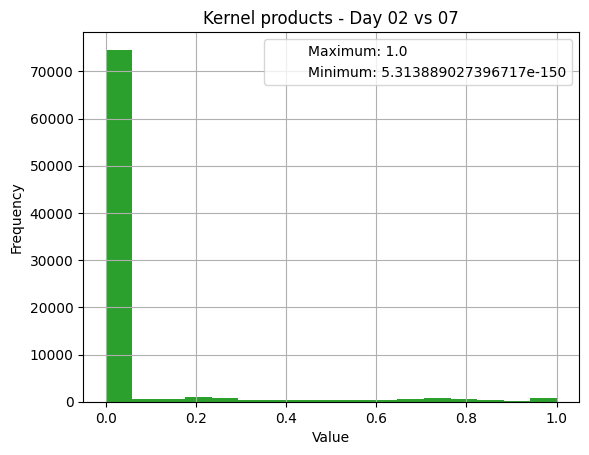

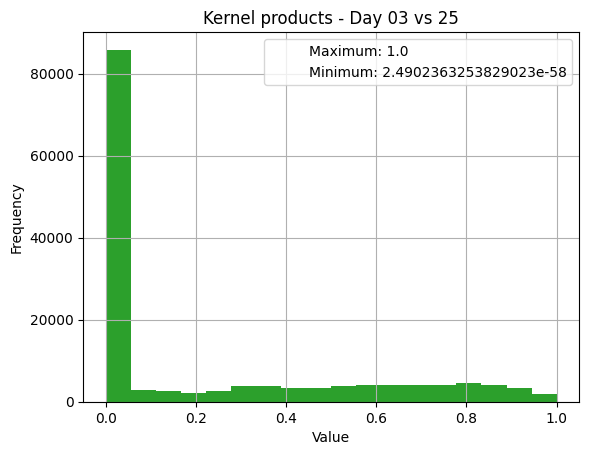

In [64]:
for index in indexes:
    i, j = index
    Ki = np.load(f'results/K_i_{i}_{j}.npy')
    Ke = np.load(f'results/K_e_{i}_{j}.npy')
    Kl = np.load(f'results/K_l_{i}_{j}.npy')
    K = Ki*Ke*Kl
    plot_histogram(K.flatten(), title = f'Kernel products - Day {i+1:02d} vs {j+1:02d}', xlabel = 'Value')

In [65]:
send_message("Finished", "My_Computer")

In [66]:
def plot_heatmap(matrix, title, labels, with_values = False, save = False, directory = None):
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    if matrix.shape[1] > 31:
        plt.xticks(np.arange(0, matrix.shape[1], 2), labels[::2], rotation=90)
        plt.yticks(np.arange(0, matrix.shape[0], 2), labels[::2])
    else:
        plt.xticks(np.arange(matrix.shape[1]), labels, rotation=90)
        plt.yticks(np.arange(matrix.shape[0]), labels)
    #plt.xticks(np.arange(matrix.shape[1]), labels, rotation=90)
    #plt.yticks(np.arange(matrix.shape[0]), labels)
    plt.xticks(np.arange(matrix.shape[1]))
    plt.yticks(np.arange(matrix.shape[0]))
    if with_values:
        for i in range(matrix.shape[0]):
            for j in range(matrix.shape[1]):
                plt.text(j, i, f'{matrix[i, j]:.1f}', ha='center', va='center', color='white')
    plt.tight_layout()
    if save:
        os.makedirs(directory, exist_ok=True)
        plt.savefig(os.path.join(directory, title + '.pdf'), bbox_inches='tight')
    else:
        plt.title(title)
        plt.show()
    plt.close()

In [67]:
K_no_weekends = np.load('spk_matrix/K_no_weekend.npy')

In [70]:
jan = [5, 6, 12, 13, 19, 20, 26, 27]
feb = [2, 3, 9, 10, 16, 17, 23, 24]
mar = [2, 3, 9, 10, 16, 17, 23, 24, 30, 31]
apr = [6, 7, 13, 14, 20, 21, 27, 28]
weekends = [f'2019-01-{i:02d}' for i in jan] + [f'2019-02-{i:02d}' for i in feb] + [f'2019-03-{i:02d}' for i in mar] + [f'2019-04-{i:02d}' for i in apr]

In [71]:
dates_true = []

for i in range(1, 32):
    current_date = f'2019-01-{i:02d}'
    if current_date not in weekends:
        dates_true.append(current_date)

for i in range(1, 29):
    current_date = f'2019-02-{i:02d}'
    if current_date not in weekends:
        dates_true.append(current_date)

for i in range(1, 32):
    current_date = f'2019-03-{i:02d}'
    if current_date not in weekends:
        dates_true.append(current_date)

for i in range(1, 31):
    current_date = f'2019-04-{i:02d}'
    if current_date not in weekends:
        dates_true.append(current_date)

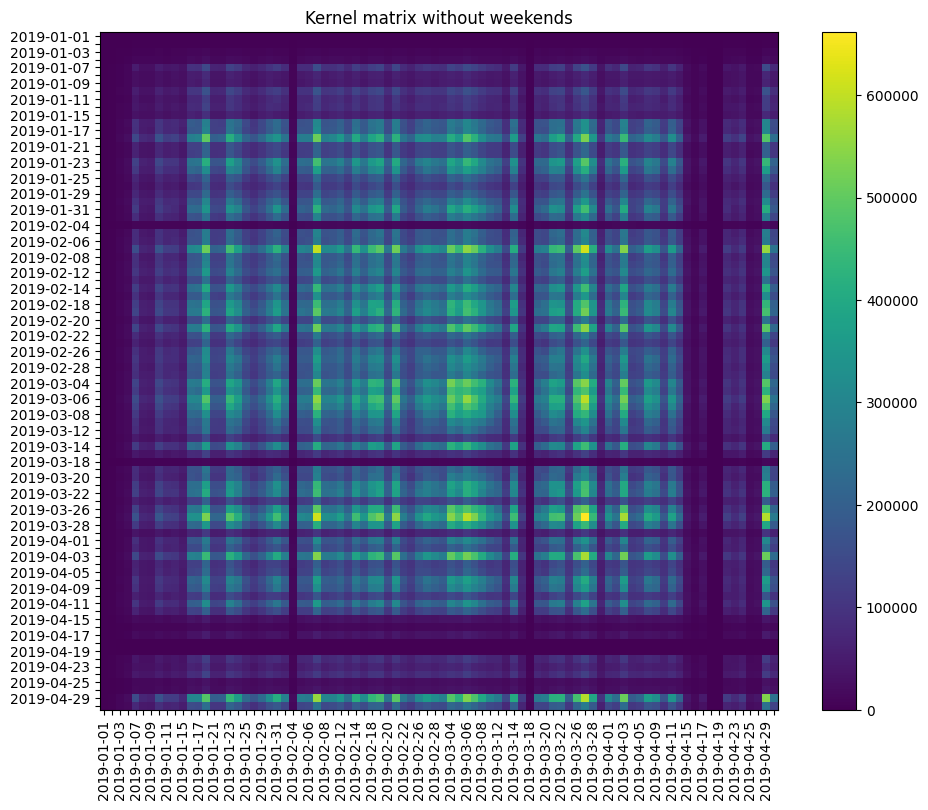

In [72]:
plot_heatmap(K_no_weekends, 'Kernel matrix without weekends', dates_true)